In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(data)

('2017-08-23',)


In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()
                        

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [15]:
# Sort the dataframe by date
prcp_data_df.set_index('date').head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


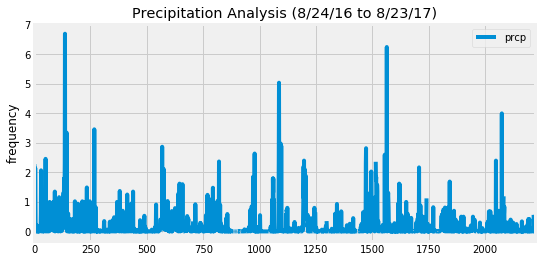

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).\
                  order_by(func.count(Measurement.station).desc()).all()
active_stations                             

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
most_active= session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).limit(1)[0][0]
most_active


'USC00519281'

In [22]:
# highest temperature recorded, and average temperature most active station?

temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()


[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
high_temp = session.query(Measurement.date, Measurement.tobs).\
          filter(Measurement.station == most_active).\
          filter(Measurement.date > year_ago).\
          order_by(Measurement.date.desc()).all()

high_temp_df = pd.DataFrame(high_temp)
high_temp_df.set_index('date').head()


,tobs
date,
2017-08-18,79.0
2017-08-17,76.0
2017-08-16,76.0
2017-08-15,77.0
2017-08-14,77.0


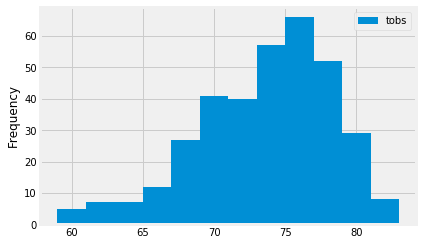

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

high_temp_df.plot(kind='hist',bins=12)

![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2016/08/24', '2017/08/23')
temps

[(58.0, 74.14387974230493, 87.0)]

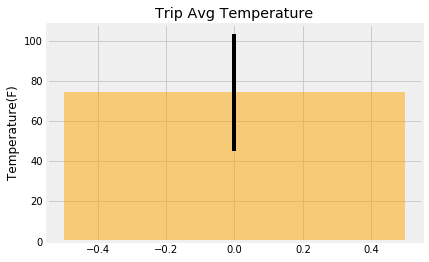

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


# trip_df = pd.DataFrame(temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
# avg_temp = trip_df['Avg Temp']
# min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
# avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
# plt.title("Trip Avg Temp", fontsize=20)
# plt.ylabel("Temp (F)")
# plt.xticks([])
# plt.grid()

# plt.show()

tmin = temps[0][0]
tavg = temps[0][1]
tmax = temps[0][2]
err = tmax-tmin

# plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=err,align="center",width=1,color="orange",alpha=0.5)
# plt.ylim=(0,120)
plt.ylabel("Temperature(F)")
plt.title("Trip Avg Temperature")
plt.savefig("Resources/Trip_Avg_Temp.jpg")
plt.show()

In [70]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


start_date = dt.date(2017,7,20)
end_date=dt.date(2017,7,30)

data = [Station.station, Station.name,Station.latitude,Station.longitude,Station .elevation,func.sum(Measurement.prcp)]
rainfall = session.query(*data).\
filter(Measurement.station==Station.station).\
filter(Measurement.date>=start_date).\
filter(Measurement.date<=end_date).group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

rainfall_table = pd.DataFrame(np.array(rainfall))

rainfall_table = rainfall_table.rename(columns={0: "Station",
                                                1: "Location",
                                                2: "Total Prcp",
                                                3:"Latitude",
                                                4:"Longitude",
                                                5:"Elevation"})
rainfall_table



,Station,Location,Total Prcp,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,8.04
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,1.6800000000000002
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,1.6600000000000001
3,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,1.1099999999999999
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.38
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.11
6,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.01


## Optional Challenge Assignment

In [73]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [81]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip_start = dt.date(2018,7,3)
trip_end = dt.date(2018,7,17)

# Stip off the year and save a list of %m-%d strings
trip_strings = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates = pd.date_range(trip_start, trip_end)
normals_list = []
for trip_date in trip_strings:
    normals_list.append(*daily_normals(trip_date))
    


In [84]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')
normals_df.head()



,Tmin,Tavg,Tmax
Date,,,
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0


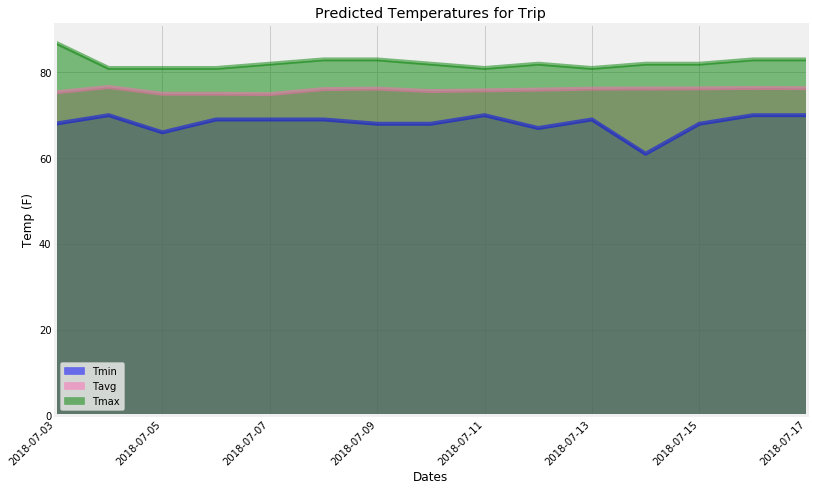

In [87]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['blue', 'hotpink', 'green']
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, title='Predicted Temperatures for Trip', rot=45)
plt.xlabel('Dates')
plt.ylabel('Temp (F)')

plt.show()